In [1]:
# Kaggle or Colab
import sys
import os
if 'kaggle_web_client' in sys.modules:
    # Do something
    pass
elif 'google.colab' in sys.modules:
    # Do something
    from google.colab import drive
    drive.mount("/content/drive")

    comp_name_official = "chaii-hindi-and-tamil-question-answering"
    comp_name_local = "Kaggle-chaii"

    !pip install --upgrade --force-reinstall --no-deps kaggle
    import json
    f = open("/content/drive/MyDrive/colab_notebooks/kaggle/kaggle.json", "r")
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

    %cd /content/drive/MyDrive/colab_notebooks/kaggle/{comp_name_local}/notebooks

Mounted at /content/drive
     |████████████████████████████████| 58 kB 3.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=88232fad9bdbccd140f6c39baeeb73f67399540527dfc2e2aba4a2d57f12caae
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
/content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-chaii/notebooks


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../input/chaii-hindi-and-tamil-question-answering/test.csv
../input/chaii-hindi-and-tamil-question-answering/sample_submission.csv
../input/chaii-hindi-and-tamil-question-answering/train.csv


In [3]:
if 'kaggle_web_client' in sys.modules:
    # Do something
    pass
elif 'google.colab' in sys.modules:
    !pip install transformers

     |████████████████████████████████| 2.8 MB 5.2 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 3.3 MB 34.1 MB/s 
     |████████████████████████████████| 895 kB 29.8 MB/s 
     |████████████████████████████████| 636 kB 49.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import re

In [5]:
from transformers import AdamW
from transformers import get_scheduler
#from transformers import BertTokenizer, BertModel

In [6]:
from transformers import BertTokenizerFast

In [7]:
from transformers import BertForQuestionAnswering

In [8]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')
#model = BertModel.from_pretrained("bert-base-multilingual-cased")

# text = "Replace me by any text you'd like."
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)

# reference: https://huggingface.co/bert-base-multilingual-cased

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [9]:
train = pd.read_csv("../input/chaii-hindi-and-tamil-question-answering/train.csv")
train.head()

,id,context,question,answer_text,answer_start,language
0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன?,206,53,tamil
1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்?,காசுமீரில்,2358,tamil
2,29d154b56,சர் அலெக்ஸாண்டர் ஃபிளெமிங் (Sir Alexander Flem...,பென்சிலின் கண்டுபிடித்தவர் யார்?,சர் அலெக்ஸாண்டர் ஃபிளெமிங்,0,tamil
3,41660850a,"குழந்தையின் அழுகையை நிறுத்தவும், தூங்க வைக்கவ...",தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பா...,தாலாட்டு,68,tamil
4,b29c82c22,சூரியக் குடும்பம் \nசூரியக் குடும்பம் (Solar S...,பூமியின் அருகில் உள்ள விண்மீன் எது?,சூரியனும்,585,tamil


num of obs w/ context_token_length being shorter than or equal to 512:
 246
num of obs w/ context_token_length being longer than 512:
 868


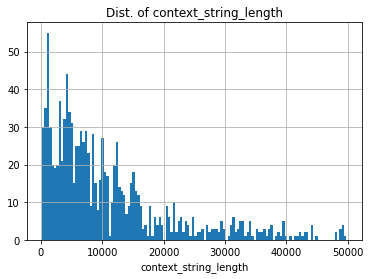

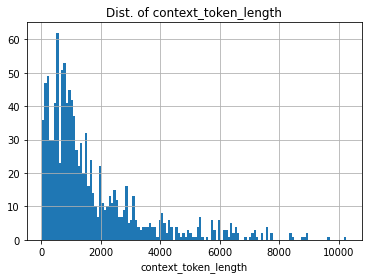

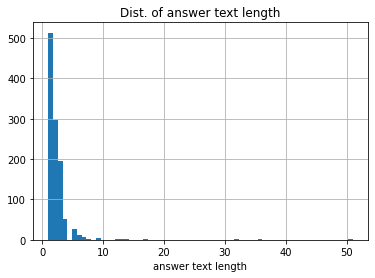

In [10]:
train["context_string_length"] = train["context"].apply(lambda x: len(x))
train["context_token_length"] = train["context"].apply(lambda x: len(x.split()))

plt.figure()
col = "context_string_length"
train[col].hist(bins=128)
plt.xlabel(f"{col}")
plt.title(f"Dist. of {col}");

plt.figure()
col = "context_token_length"
train[col].hist(bins=128)
plt.xlabel(f"{col}")
plt.title(f"Dist. of {col}");
print(f"num of obs w/ {col} being shorter than or equal to 512:\n", len(train[train[col]<=512]))
print(f"num of obs w/ {col} being longer than 512:\n", len(train[train[col]>512]))

plt.figure()
train["answer_text"].apply(lambda x: len(x.split())).hist(bins=64)
plt.xlabel("answer text length")
plt.title("Dist. of answer text length");

**最大512長で分割**<br><br>

The hack is to split the clinical notes into multiple sub-notes such that every sub-note when concatenated with input question, gives close to 512 tokens. After concatenating the input question with sub-note, there are two possibilities: 1) if sub-note contains the ground truth answer, label the answer with its start and end position in sub-note 2) if sub-note does not contain ground truth answer, label the start and end position as 0 (points to [CLS] token).<br><br>
reference: [Adapting BERT question answering for the medical domain](https://medium.com/analytics-vidhya/adapting-bert-question-answering-for-the-medical-domain-2085ada8ceb1)

オーバーラップは60 tokens とする.

In [11]:
# Text cleansing for context

#alphabets = "([A-Za-z])"
alphabets = "([\u0900-\u097F\u0B80-\u0BFF])" # Hindi & Tamil
prefixes = re.compile("(Mr|St|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|Mt)[.]")
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = re.compile("[.](co|net|org|io|gov|edu|us)")
etal = re.compile(r"(\bet al)[.]")
urls = re.compile("(www)[.]")
digits =  re.compile("[.]([0-9])")

def split_into_sentences(text):
    """
    This function will be applied to context in df
    ----------------------------------------------
    Args: 
        text: str
    Returns:
        sentences: List[str]
    """
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = prefixes.sub("\\1<prd>",text)
    text = websites.sub("<prd>\\1",text)
    text = urls.sub("\\1<prd>",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    text = etal.sub("\\1<prd>", text)
    text = digits.sub("<prd>\\1",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    if sentences[-1] == '':
        sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

def clean_text(txt, apply_space_norm=False, strip=False):
    """
    This function will be applied to question and answer in df
    ----------------------------------------------------------
    Args: 
        text: str
    Returns:
        text: str
    """
    txt = re.sub('\[[0-9]\]', '', txt) # remove Wikipedia's quotes
    if apply_space_norm:
        txt = re.sub('[^A-Za-z\u0900-\u097F\u0B80-\u0BFF0-9]+', ' ', str(txt).lower()) # Hindi: \u0900-\u097F, Tamil: \u0B80-\u0BFF
    if strip:
        txt = txt.strip()
    return txt


def shorten_sentences(sentences, max_length=512, overlap=60):
    """
    If a sentence is longer than `max_length`, break it into chunks of 
    length `max_length` with an overlap of length `overlap`.
    
    e.g. if the sentence has 50 tokens, max_length is 20, and overlap is 10.
    Then the first sentence will be token_i where i in [0,20)
    Second sentence will be token_i in [10,30).
    Third sentence [20, 40)
    Fourth [30, 50)
    Fifth [40, 60)
    ------------------------------------------------------------------------
    Args:
        sentences: List[str]
        max_length: int
        overlap: int
    Returns:
        shortend_sentences: List[str]
    """
    shortened_sentences = []
    for sentence in sentences:
        sentence = clean_text(sentence, apply_space_norm=True)
        words = sentence.split()
        num_words = len(words)
        if num_words > max_length:
            for start_index in range(0, num_words, max_length - overlap):
                shortened_sentences.append(' '.join(words[start_index:start_index+max_length]))
        else:
            shortened_sentences.append(sentence)
    return shortened_sentences

# refenrece:
# [1] https://stackoverflow.com/questions/41356013/how-to-detect-if-a-string-contains-hindi-devnagri-in-it-with-character-and-wor
# [2] https://en.wikipedia.org/wiki/Unicode_block
# [3] https://www.kaggle.com/nbroad/no-training-question-answering-model?scriptVersionId=66240356

In [12]:
train["context_sentences"] = train["context"].apply(clean_text).apply(split_into_sentences).apply(shorten_sentences)

In [13]:
train["question"] = train["question"].apply(clean_text, apply_space_norm=True, strip=True)

In [14]:
train["answer_text"] = train["answer_text"].apply(clean_text, apply_space_norm=True, strip=True)

In [15]:
train["answer_text"][2]

'சர் அலெக்ஸாண்டர் ஃபிளெமிங்'

In [16]:
# res = []
# for sentence in train["context_sentences"][2]:
#     res.append(sentence.find(train["answer_text"][2]))

# print(res)

In [17]:
train["context_sentences"][2]

['சர் அலெக்ஸாண்டர் ஃபிளெமிங் sir alexander fleming ஆகஸ்ட் 6 1881 மார்ச் 11 1955 நுண்ணுயிர் கொல்லியான சிதைநொதியைக் கண்டுபிடித்தவர் ',
 'மேலும் நுண்ணுயிர் கொல்லியான பெனிசிலினை பெனிசிலியம் நொடேடம் penicillium notatum என்ற பூஞ்சையிலிருந்து பிரித்தெடுத்தார் ',
 'பெனிசிலின் கண்டுபிடிப்பு உலகம் அறிந்துள்ள மருத்துவ முன்னேற்றங்களுள் பெனிசிலின் கண்டுபிடிப்பு தனிச்சிறப்பு வாய்ந்தது ',
 'பெனிசிலின் காலத்திற்கு முன் பிரசவத்தில் பெண்கள் இறப்பதும் பிறந்தபின் குழந்தைகள் இறப்பதும் சர்வ சாதாரணம் ',
 'லேசான சிராய்ப்புகளும் கீறல்களும் கூட மரணத்திற்கு இட்டுச் சென்றன ',
 'ஒரு நுண்ணுயிரை வைத்து இன்னொன்றைக் கொல்லமுடிகிற பெனிஸிலின் போன்ற நச்சுமுறி மருந்துகள் கண்டுபிடிக்கப்பட்ட பிறகுதான் பல நோய்களிலிருந்து மனிதர்களைக் காப்பாற்ற முடிந்தது ',
 'பெனிசிலினைக் கண்டு பிடித்து நவீன நச்சுமுறி மருந்துகள் யுகத்தைத் தொடங்கிவைத்த பெருமைக்குரிய விஞ்ஞானிதான் அலெக் ஸாண்டர் ஃப்பௌமிங் ',
 'பெனிசிலின் உலகெங்கிலும் உள்ள 20 கோடி மக்களின் உயிரைக் காப்பாற்றியுள்ளது என்கிறது ஒரு மதிப்பீடு ',
 'பிறப்பு ஃப்ளெமிங் 1881 ஆகஸ்ட் 6 அன்று ஸ்

In [18]:
#train[train["answer_text"].apply(lambda x: len(x.split()))>50]

In [19]:
#train.loc[648, "answer_text"]

In [20]:
#train["answer_start"].min()

In [21]:
#train[train["answer_text"]=="IBM"]

In [22]:
# context_5 = train.loc[5, "context"]
# context_5

In [23]:
# answer_text_5 = train.loc[5, "answer_text"]
# answer_text_5

In [24]:
# # Get the string-wise start position of answer_text
# substring_start_pos = context_5.find(answer_text_5)
# print(substring_start_pos)

In [25]:
# # Get the token-wise start position of answer_text
# tokenwise_start_pos = len(context_5[:substring_start_pos+1].split()) - 1
# print(tokenwise_start_pos)

In [26]:
# context_5.split()[tokenwise_start_pos]

In [27]:
train.loc[0, "answer_text"]

'206'

In [28]:
train.loc[0, "context_sentences"]

['ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின்வரும் 206 மார்பெலும்பு மூன்று பகுதிகளாகக் கருதப்பட்டால் 208 எண்ணிக்கையான எலும்புகளைக் கொண்டிருக்கும் ',
 'இந்த எண்ணிக்கை உடற்கூட்டியல் வேறுபாடுகளைப் பொறுத்து மாறுபடக்கூடும் ',
 'எடுத்துக்காட்டாக மிகக் குறைந்த எண்ணிக்கையான மனிதர்களில் ஒரு மேலதிக விலா எலும்பு கழுத்துவில் அல்லது ஒரு மேலதிகமான கீழ் முதுகெலும்பு காணப்படுவதுண்டு இணைந்த சில எலும்புகளைத் தனி எலும்பாகக் கருதாவிடின் ஐந்து இணைந்த திருவெலும்பு மூன்று 3 5 குயிலலகு எலும்புகள் சேர்ந்து 26 எண்ணிக்கையிலான முதுகெலும்புகள் 33 ஆகக் கருதப்படலாம் ',
 'மனித மண்டையோட்டில் 22 எலும்புகள் காதுச் சிற்றென்புகளைத் தவிர உள்ளன இவை எட்டு மண்டையறை cranium எலும்புகளாகவும் 14 முக எலும்புகளாகவும் facial bones பிரிக்கப்பட்டுள்ளன ',
 ' தடித்த எண்கள் அருகிலுள்ள படத்தில் காணும் எண்களைக் குறிக்கின்றன ',
 ' மண்டையறை எலும்புகள் 8 1 நுதலெலும்பு frontal bone 2 சுவரெலும்பு parietal bone 2 3 கடைநுதலெலும்பு temporal bone 2 4 பிடர் எலும்பு occipital bone ஆப்புரு எலும்பு sphenoid bone நெய்யரியெலும்பு ethmoid bone முக எலு

In [29]:
# sentence_a = "a name of flower"
# sentence_b = "mountain tree"
# sentence_a.find(sentence_b)

In [30]:
def get_proper_answer_start(df, run_checker=False):
    """
    Args:
        df: pandas.DataFrame
        run_checker: bool --default False
    Returns: 
        df: pandas.DataFrame
    """
    #### RIOW
    # df["does_answer_start_within"] = 0 # flags of the existence of answer start on per with context sentence order
    # df["does_answer_start_within"] = df["does_answer_start_within"].astype("object")
    # df["answer_start_tw"] = 0 # token-wise answer start position
    df["answer_start_tw_per_sentence_s"] = 0
    df["answer_start_tw_per_sentence_s"] = df["answer_start_tw_per_sentence_s"].astype("object")
    #### RIOWRIOW
    for i,row in df.iterrows():
        
        # Check if the answer_text is in the context sentence
        #### RIOW
        row_context_sentences = row["context_sentences"]
        row_answer_text = row["answer_text"]

        #does_answer_start_within = []
        answer_start_tw_per_sentence = []
        for context_sentence in row_context_sentences:
            answer_start_sw = context_sentence.find(row_answer_text)
            if answer_start_sw==-1:
                #does_answer_start_within.append(0)
                #answer_start_tw_per_sentence.append(0)
                answer_start_tw = answer_start_sw
            else:
                #does_answer_start_within.append(1)
                answer_start_tw = len(context_sentence[:answer_start_sw+1].split()) - 1
            answer_start_tw_per_sentence.append(answer_start_tw)
        
        # # Obtain answer_start of token-wise level
        # row_context_find_answer_text = row["context"].find(row["answer_text"])
        # row_answer_start = row["answer_start"]
        
        # if run_checker:
        #     if row_context_find_answer_text != row_answer_start:
        #         raise ValueError("An inaccurate answer_start found!")
        
        # #df.loc[i, "does_answer_start_within"] = does_answer_start_within
        # df.at[i, "does_answer_start_within"] = does_answer_start_within
        # df.loc[i, "answer_start_tw"] = len(row["context"][:row_answer_start+1].split()) - 1

        df.at[i, "answer_start_tw_per_sentence_s"] = answer_start_tw_per_sentence

        #### RIOWRIOW

    return df

In [31]:
train = get_proper_answer_start(train)

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              1114 non-null   object
 1   context                         1114 non-null   object
 2   question                        1114 non-null   object
 3   answer_text                     1114 non-null   object
 4   answer_start                    1114 non-null   int64 
 5   language                        1114 non-null   object
 6   context_string_length           1114 non-null   int64 
 7   context_token_length            1114 non-null   int64 
 8   context_sentences               1114 non-null   object
 9   answer_start_tw_per_sentence_s  1114 non-null   object
dtypes: int64(3), object(7)
memory usage: 87.2+ KB


In [33]:
#train["answer_start_tw"].min()

In [34]:
# # As [CLS] token to be prepended at the very first position
# train["answer_start_tw"] = train["answer_start_tw"] + 1
#train["answer_start_tw"].min()

In [35]:
#train["answer_start"].min()

In [36]:
train["answer_start_tw_per_sentence_s"]

0       [6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1...
1       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
2       [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1...
3       [7, 0, 3, 0, 0, -1, -1, 6, 10, -1, 3, -1, -1, ...
4       [-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1...
                              ...                        
1109                                 [-1, 80, 90, -1, -1]
1110                                                  [0]
1111                            [25, -1, 91, -1, -1, 291]
1112    [7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1...
1113                                    [-1, 275, -1, -1]
Name: answer_start_tw_per_sentence_s, Length: 1114, dtype: object

In [37]:
def read_chaii(df):
    """
    Args:
        df: pd.DataFrame
    Returns:
        contexts: List[str]
        questions: List[str]
        answers: List[Dict[str:int]]
    """
    contexts = []
    questions = []
    answers = []
    for i,row in df.iterrows():
        row_context_sentences = row["context_sentences"]
        #### RIOW
        #does_answer_start_within = row["does_answer_start_within"]
        row_answer_start_tw_per_sentence_s = row["answer_start_tw_per_sentence_s"]
        #### RIOWRIOW
        
        row_question = row["question"]
        
        #### RIOW
        row_answer_text = row["answer_text"]
        # row_answer_start = row["answer_start_tw"]
        # row_answer_end = row_answer_start + len(row_answer_text.split()) - 1
        #### RIOWRIOW
        
        #### RIOW
        #current_pos = 0
        #for dasw, context_sentence in zip(does_answer_start_within, row_context_sentences):
        for answer_start_tw_per_sentence, context_sentence in zip(row_answer_start_tw_per_sentence_s, row_context_sentences):
            contexts.append(context_sentence)
            questions.append(row_question)
            
            # if dasw == 1:
            #     row_answer_start = row_answer_start - current_pos + 1 # [CLS] token position always sits at 0 position
            #     row_answer_end = row_answer_end - current_pos + 1 # [CLS] token position always sits at 0 position
            # else:
            #     row_answer_start = 0 # [CLS] token position
            #     row_answer_end = 0 # [CLS] token position


            if answer_start_tw_per_sentence == -1:
                answer_start_tw_per_sentence = 0 # [CLS] token position
                answer_end_tw_per_sentence = 0 # [CLS] token position
            else:
                answer_start_tw_per_sentence += 1 # assuming [CLS] token to be inserted at 0 position
                answer_end_tw_per_sentence = answer_start_tw_per_sentence + len(row_answer_text.split()) - 1

            #current_pos += len(context_sentence.split())
            
            answer = {}
            answer["text"] = row_answer_text
            # answer["answer_start"] = row_answer_start
            # answer["answer_end"] = row_answer_end
            answer["answer_start"] = answer_start_tw_per_sentence
            answer["answer_end"] = answer_end_tw_per_sentence
            answers.append(answer)

        #### RIOWRIOW

    return contexts, questions, answers

In [38]:
# def read_chaii(df, max_len=512, overlap=60):
#     """
#     Args:
#         df: pd.DataFrame
#         max_len: int --default 512
#         overlap: int --default 60
#     Returns:
#         contexts: List[str]
#         questions: List[str]
#         answers: List[Dict[str:int]]
#     """
#     contexts = []
#     questions = []
#     answers = []
#     for i,row in df.iterrows():
#         #### RIOW
#         # context = row["context"]
#         # context_len = len(context.split())
#         context_sentences = row["context_sentences"]
#         does_answer_start_within = row["does_answer_start_within"]
#         #### RIOWRIOW
#         question = row["question"]
        
#         row_answer_text = row["answer_text"]
#         row_answer_start = row["answer_start_tw"]
#         row_answer_end = row_answer_start + len(row_answer_text.split()) - 1
        
#         #### RIOW
#         # for j in range(0, context_len, max_len-overlap):
#         current_pos = 0
#         for dasw,context_sentence in zip(does_answer_start_within, context_sentences):
#         #### RIOWRIOW
#             contexts.append(context_sentence)
#             questions.append(question)
            
#             #### RIOW
#             # span_start_pos = j
#             # span_end_pos = min(j + max_len, context_len-1)
#             # if (span_start_pos <= row_answer_start-1) & (row_answer_end-1 <= span_end_pos):
#             #     pass
#             # else:
#             #     row_answer_start = 0 # [CLS] token position
#             #     row_answer_end = 0 # [CLS] token position
#             if dasw == 1:
#                 # ToDo: Update row_answer_start & row_answer_end
#                 row_answer_start = row_answer_start - current_pos + 1 # [CLS] token position always sits at 0 position
#                 row_answer_end = row_answer_end - current_pos + 1 # [CLS] token position always sits at 0 position
#             else:
#                 row_answer_start = 0 # [CLS] token position
#                 row_answer_end = 0 # [CLS] token position

#             current_pos += len(context_sentence.split())
#             #### RIOWRIOW
            
#             answer = {}
#             answer["text"] = row_answer_text
#             answer["answer_start"] = row_answer_start
#             answer["answer_end"] = row_answer_end
#             answers.append(answer)

#     return contexts, questions, answers

In [39]:
train_contexts, train_questions, train_answers = read_chaii(train)

In [40]:
assert len(train_contexts) == len(train_questions) == len(train_answers)
print(len(train_contexts), len(train_questions), len(train_answers))

56090 56090 56090


In [41]:
n = 100
train_contexts[:n]

['ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின்வரும் 206 மார்பெலும்பு மூன்று பகுதிகளாகக் கருதப்பட்டால் 208 எண்ணிக்கையான எலும்புகளைக் கொண்டிருக்கும் ',
 'இந்த எண்ணிக்கை உடற்கூட்டியல் வேறுபாடுகளைப் பொறுத்து மாறுபடக்கூடும் ',
 'எடுத்துக்காட்டாக மிகக் குறைந்த எண்ணிக்கையான மனிதர்களில் ஒரு மேலதிக விலா எலும்பு கழுத்துவில் அல்லது ஒரு மேலதிகமான கீழ் முதுகெலும்பு காணப்படுவதுண்டு இணைந்த சில எலும்புகளைத் தனி எலும்பாகக் கருதாவிடின் ஐந்து இணைந்த திருவெலும்பு மூன்று 3 5 குயிலலகு எலும்புகள் சேர்ந்து 26 எண்ணிக்கையிலான முதுகெலும்புகள் 33 ஆகக் கருதப்படலாம் ',
 'மனித மண்டையோட்டில் 22 எலும்புகள் காதுச் சிற்றென்புகளைத் தவிர உள்ளன இவை எட்டு மண்டையறை cranium எலும்புகளாகவும் 14 முக எலும்புகளாகவும் facial bones பிரிக்கப்பட்டுள்ளன ',
 ' தடித்த எண்கள் அருகிலுள்ள படத்தில் காணும் எண்களைக் குறிக்கின்றன ',
 ' மண்டையறை எலும்புகள் 8 1 நுதலெலும்பு frontal bone 2 சுவரெலும்பு parietal bone 2 3 கடைநுதலெலும்பு temporal bone 2 4 பிடர் எலும்பு occipital bone ஆப்புரு எலும்பு sphenoid bone நெய்யரியெலும்பு ethmoid bone முக எலு

In [42]:
train_questions[:n]

['மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன',


In [43]:
train_answers[:n]

[{'answer_end': 7, 'answer_start': 7, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_s

**PyTorch Dataset & DataLoader**<br>
reference: https://huggingface.co/transformers/custom_datasets.html#question-answering-with-squad-2-0

In [44]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)

In [45]:
# train_encodingsを表示させようとするとmemory errorになるので注意
print(type(train_encodings))
print(len(train_encodings))

<class 'transformers.tokenization_utils_base.BatchEncoding'>
3


In [46]:
train_answers

[{'answer_end': 7, 'answer_start': 7, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 0, 'answer_s

In [47]:
def add_token_positions(encodings, answers):
    """
    Args:
        encodings: transformers.tokenization_utils_base.BatchEncoding
        answers: List[Dict[str:int]]
    Returns:
        None
    """
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        
        #### RIOW
        #end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length
        #### RIOWRIOW
    
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

In [48]:
add_token_positions(train_encodings, train_answers)
# reference: https://www.gitmemory.com/issue/huggingface/transformers/12201/862549850
# "Why not use tokenizerfast?"

In [49]:
class ChaiiDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [50]:
train_dataset = ChaiiDataset(train_encodings)

In [51]:
# batch_size=16
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
#train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

Train

In [52]:
# Model
model = BertForQuestionAnswering.from_pretrained("bert-base-multilingual-cased")

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-bas

In [53]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Scheduler
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [54]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [ ]:
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)

In [55]:
if 'kaggle_web_client' in sys.modules:
    output_model = "./model.pth"
elif 'google.colab' in sys.modules:
    dname = "localnb002-fine-tune"
    !mkdir {dname}
    output_model = dname+'/model.pth'

mkdir: cannot create directory ‘localnb002-fine-tune’: File exists


In [56]:
# load
checkpoint = torch.load(output_model, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

<All keys matched successfully>

In [57]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [58]:
model.eval()
progress_bar = tqdm(range(len(train_dataloader)))
scores = []
for batch in train_dataloader:
    input_ids = batch['input_ids'].to(device)
    # attention_mask = batch['attention_mask'].to(device)
    gt_start_positions = batch['start_positions'].to(device)
    gt_end_positions = batch['end_positions'].to(device)
    
    outputs = model(input_ids)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    # Get the most likely beginning of answer with the argmax of the score
    answer_start = torch.argmax(answer_start_scores)
    # Get the most likely end of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1 

    pred_answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
    gt_answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[gt_start_positions:gt_end_positions]))
    
    scores.append(jaccard(gt_answer, pred_answer))
    
    progress_bar.update(1)

print(scores)

  0%|          | 0/7012 [00:00<?, ?it/s]

TypeError: ignored

In [ ]:
# inputs = tokenizer(row_question, context_sentence, 
#                     add_special_tokens=True,
#                     max_length=512,
#                     padding=True, 
#                     truncation=True, 
#                     return_tensors="pt")
# inputs.to(device)
# input_ids = inputs["input_ids"].tolist()[0]
# outputs = model(**inputs)
# answer_start_scores = outputs.start_logits
# answer_end_scores = outputs.end_logits

# # Get the most likely beginning of answer with the argmax of the score
# answer_start = torch.argmax(answer_start_scores)
# # Get the most likely end of answer with the argmax of the score
# answer_end = torch.argmax(answer_end_scores) + 1

# answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
# prediction_strings.append(answer)
# prediction_scores.append(-1)

# # refenrece: https://huggingface.co/transformers/task_summary.html#extractive-question-answering

In [ ]:
def save(model, optimizer):
    """
    Args:
        model: PyTorch model object
        optimizer: PyTorch optimizer object
    Returns:
        None
    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)

In [ ]:
# Save the fine-tuned model
save(model, optimizer)

Export to Kaggle Dataset

In [ ]:
if 'google.colab' in sys.modules:
    !kaggle datasets init -p {dname}

    with open(f"{dname}/dataset-metadata.json", "r") as jsonFile:
        data = json.load(jsonFile)

    data["id"] = f"riow1983/{dname}"
    data["title"] = dname

    with open(f"{dname}/dataset-metadata.json", "w") as jsonFile:
        json.dump(data, jsonFile)

    !kaggle datasets create -p {dname} --dir-mode zip

Data package template written to: localnb002-fine-tune/dataset-metadata.json
Starting upload for file model.pth
100% 1.98G/1.98G [00:27<00:00, 78.5MB/s]
Upload successful: model.pth (2GB)
Your private Dataset is being created. Please check progress at /api/v1/datasets/status//riow1983/localnb002-fine-tune


In [ ]:
outputs

In [ ]:
outputs[0]

tensor(0.5376, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
outputs.loss

tensor(0.5376, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
outputs.start_logits.shape

torch.Size([2, 512])

In [ ]:
outputs.end_logits.shape

torch.Size([2, 512])

In [ ]:
len(outputs)

3

In [ ]:
#pred_start_positions = torch.argmax(outputs.start_logits, dim=-1)
#pred_end_positions = torch.argmax(outputs.end_logits, dim=-1)

NameError: ignored